# Introduction
Customer churn prediction is a critical task for businesses aiming to retain customers and reduce revenue loss. This notebook demonstrates how to build and evaluate multiple machine learning models to predict customer churn using Python's pandas and scikit-learn libraries.

In [ ]:
# Install specific versions of libraries
!pip install scikit-learn==1.3.2 pandas==2.1.0 seaborn==0.12.0 matplotlib==3.7.1

# Import necessary libraries after the installations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style for better visuals
sns.set(style="whitegrid")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 2.1.0 which is incompatible.
statsmodels 0.14.3 requires pandas!=2.1.0,>=1.4, but you have pandas 2.1.0 which is incompatible.


### Loading the Dataset

In [ ]:
# Load the dataset
df = pd.read_csv('/content/sample_data/customer_churn_data.csv')

# Display the first few rows
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Exploratory Data Analysis (EDA)

Dataset contains 7043 rows and 21 columns.

Missing Values in Each Column:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


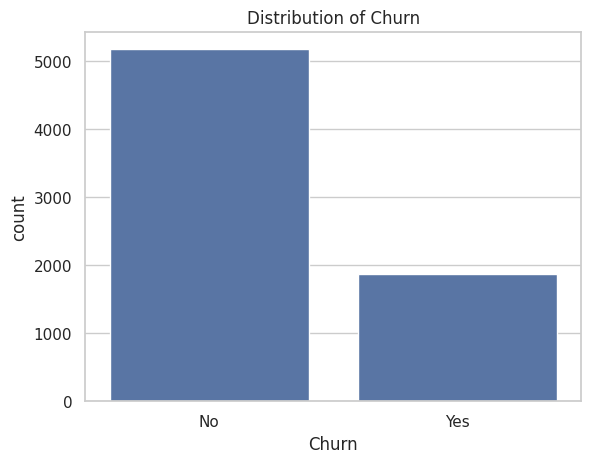

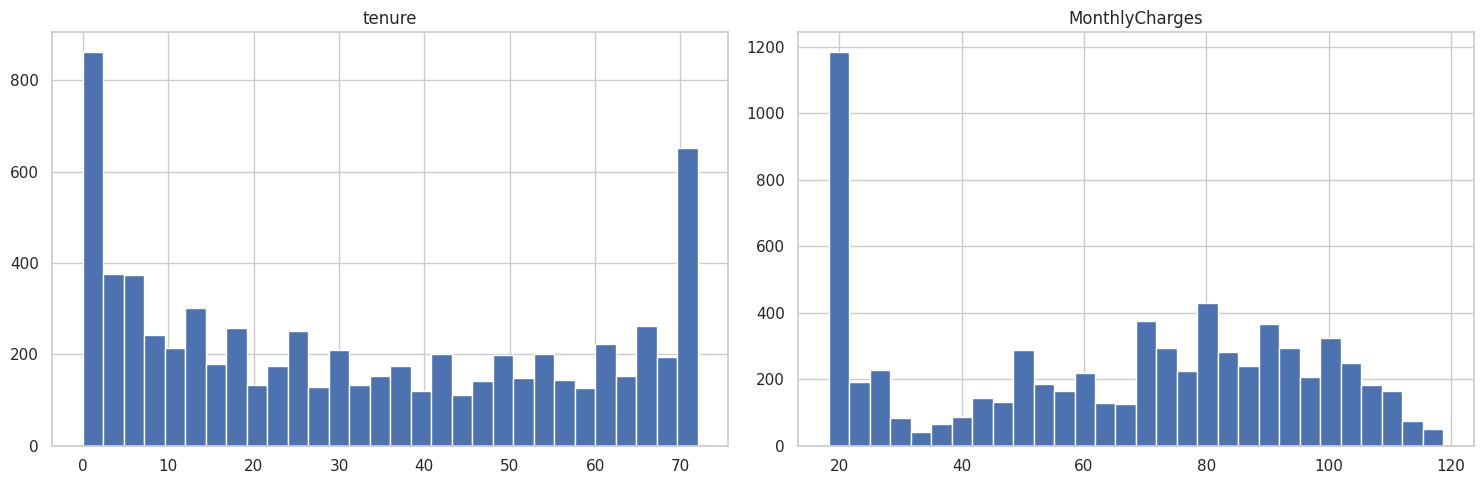

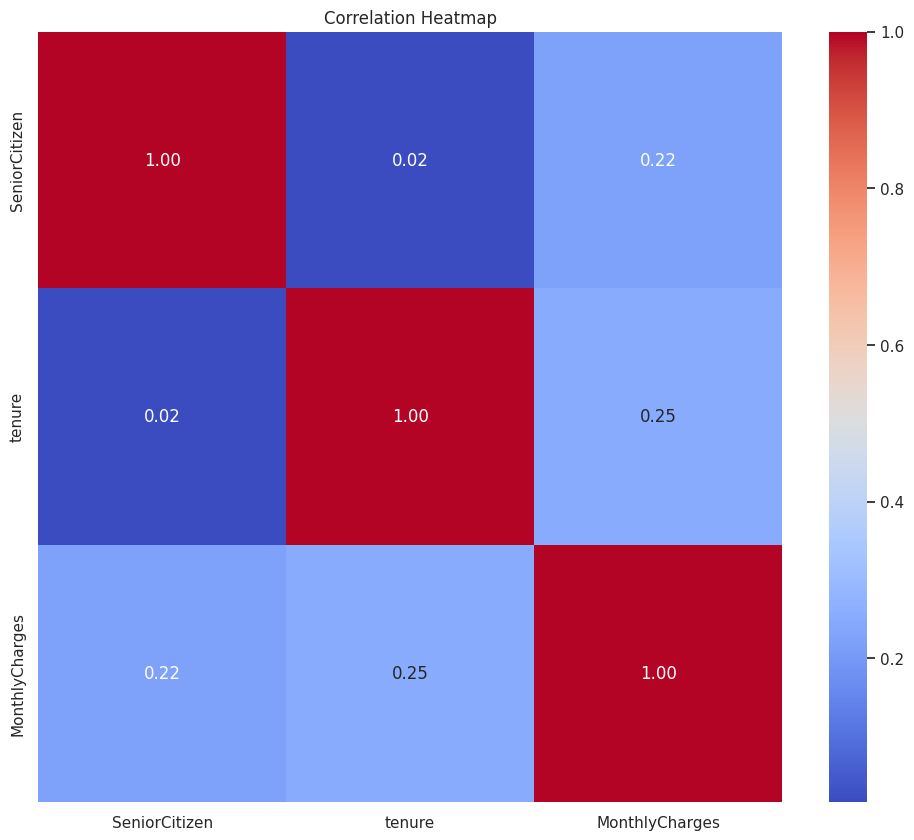

In [ ]:
# Check the shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:\n", missing_values)

# Summary statistics
df.describe()

# Distribution of the target variable
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()

# Visualize distribution of numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features].hist(bins=30, figsize=(15, 5))
plt.tight_layout()
plt.show()

# Filter the DataFrame to include only numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


### Data Preprocessing

In [ ]:
# Drop 'customerID' as it does not contribute to churn prediction
df.drop('customerID', axis=1, inplace=True)

# Handle missing values in 'TotalCharges'
# Convert 'TotalCharges' to numeric, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check missing values after conversion
print("\nMissing Values After Conversion:\n", df.isnull().sum())

# Fill missing 'TotalCharges' with median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Verify no missing values remain
print("\nMissing Values After Imputation:\n", df.isnull().sum())

# Encode 'gender' column
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Female=0, Male=1

# Encode binary categorical variables
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Encode 'MultipleLines' - considering 'No phone service' as separate category
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})
df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0})

# Encode 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
# 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'

# List of categorical columns to encode
categorical_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies', 'Contract', 'PaymentMethod']

# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature Scaling for numerical features
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

# Display the preprocessed data
df.head()



Missing Values After Conversion:
 gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Missing Values After Imputation:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.277445,0,0,1,-1.160323,-0.994242,...,False,False,False,False,False,False,False,False,True,False
1,1,0,0,0,0.066327,1,0,0,-0.259629,-0.173244,...,False,False,False,False,False,True,False,False,False,True
2,1,0,0,0,-1.236724,1,0,1,-0.362660,-0.959674,...,False,False,False,False,False,False,False,False,False,True
3,1,0,0,0,0.514251,0,0,0,-0.746535,-0.194766,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,0,-1.236724,1,0,1,0.197365,-0.940470,...,False,False,False,False,False,False,False,False,True,False


### Feature Engineering

In [ ]:
# Create 'FamilySize' feature by combining 'Dependents' and 'Partner'
df['FamilySize'] = df['Dependents'] + df['Partner']

# Drop 'Dependents' and 'Partner' if 'FamilySize' is sufficient
df.drop(['Dependents', 'Partner'], axis=1, inplace=True)

# Create 'HasMultipleServices' feature
service_cols = ['PhoneService', 'MultipleLines', 'InternetService_Fiber optic',
               'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
               'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
               'StreamingMovies_Yes']
df['HasMultipleServices'] = df[service_cols].sum(axis=1)

# Drop individual service columns if 'HasMultipleServices' is sufficient
df.drop(service_cols, axis=1, inplace=True)

# Display the updated DataFrame
df.head()


,gender,SeniorCitizen,tenure,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,OnlineSecurity_No internet service,OnlineBackup_No internet service,DeviceProtection_No internet service,TechSupport_No internet service,StreamingTV_No internet service,StreamingMovies_No internet service,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,FamilySize,HasMultipleServices
0,0,0,-1.277445,1,-1.160323,-0.994242,0,False,False,False,False,False,False,False,False,False,True,False,1,1
1,1,0,0.066327,0,-0.259629,-0.173244,0,False,False,False,False,False,False,True,False,False,False,True,0,3
2,1,0,-1.236724,1,-0.362660,-0.959674,1,False,False,False,False,False,False,False,False,False,False,True,0,3
3,1,0,0.514251,0,-0.746535,-0.194766,0,False,False,False,False,False,False,True,False,False,False,False,0,3
4,0,0,-1.236724,1,0.197365,-0.940470,1,False,False,False,False,False,False,False,False,False,True,False,0,2


### Splitting the Data

In [ ]:
# Define features and target variable
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display the shape of the splits
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (5634, 19), Testing set: (1409, 19)


### Model Training and Evaluation

In [ ]:
# Initialize Logistic Regression
logreg = LogisticRegression(random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predict on test data
y_pred_logreg = logreg.predict(X_test)

# Evaluate the model
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_logreg))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))


Logistic Regression
Accuracy: 0.7906316536550745
ROC-AUC: 0.706364153039345

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



In [ ]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Classifier
Accuracy: 0.7814052519517388
ROC-AUC: 0.6830078276369836

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [ ]:
# Initialize Support Vector Machine
svm = SVC(random_state=42, probability=True)

# Train the model
svm.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm.predict(X_test)

# Evaluate the model
print("Support Vector Machine")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("ROC-AUC:", roc_auc_score(y_test, svm.predict_proba(X_test)[:,1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Support Vector Machine
Accuracy: 0.78708303761533
ROC-AUC: 0.8155803559895631

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.64      0.44      0.53       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.79      0.77      1409



In [ ]:
# Initialize K-Nearest Neighbors
knn = KNeighborsClassifier()

# Train the model
knn.fit(X_train, y_train)

# Predict on test data
y_pred_knn = knn.predict(X_test)

# Evaluate the model
print("K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("ROC-AUC:", roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


K-Nearest Neighbors
Accuracy: 0.7643718949609652
ROC-AUC: 0.7759358288770053

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1035
           1       0.56      0.49      0.53       374

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.76      0.76      0.76      1409



In [ ]:
# Initialize Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)

# Train the model
gb.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gb.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("ROC-AUC:", roc_auc_score(y_test, gb.predict_proba(X_test)[:,1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Classifier
Accuracy: 0.7906316536550745
ROC-AUC: 0.8399713244981787

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



### Comparing Models

In [ ]:
# Create a DataFrame to store evaluation metrics
models = ['Logistic Regression', 'Random Forest', 'SVM', 'KNN', 'Gradient Boosting']

accuracy = [
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_gb)
]
roc_auc = [
    roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]),
    roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]),
    roc_auc_score(y_test, svm.predict_proba(X_test)[:,1]),
    roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]),
    roc_auc_score(y_test, gb.predict_proba(X_test)[:,1])
]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'ROC-AUC': roc_auc
})

# Display the comparison
comparison_df


,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.790632,0.835811
1,Random Forest,0.781405,0.820034
2,SVM,0.787083,0.815580
3,KNN,0.764372,0.775936
4,Gradient Boosting,0.790632,0.839971


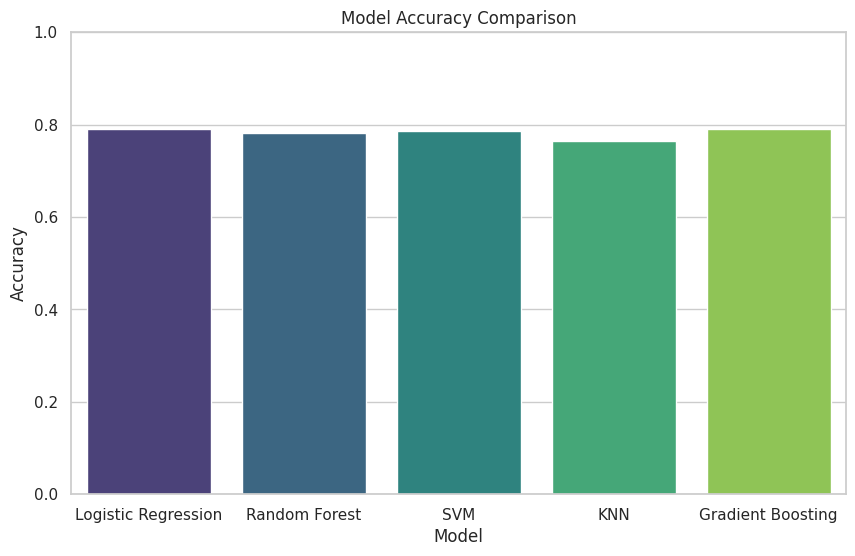

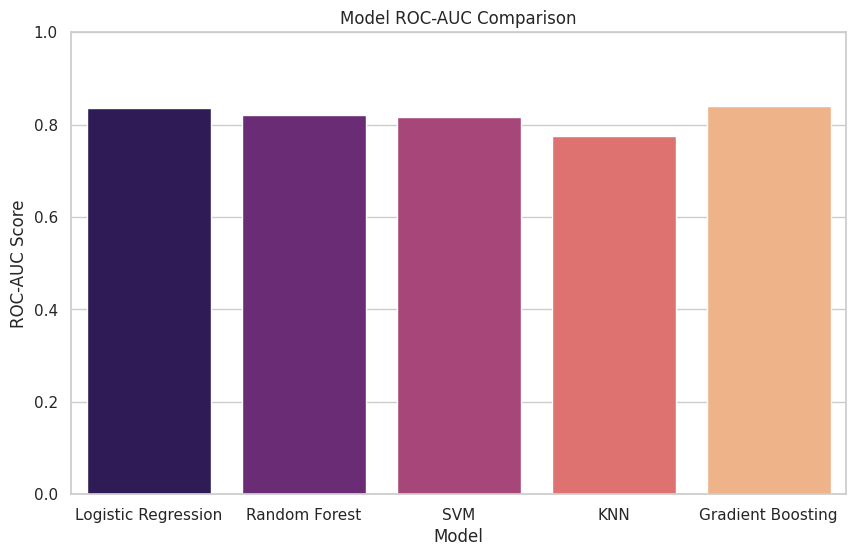

In [ ]:
## Visualization

# Set the figure size
plt.figure(figsize=(10,6))

# Plot Accuracy
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

# Plot ROC-AUC
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='ROC-AUC', data=comparison_df, palette='magma')
plt.title('Model ROC-AUC Comparison')
plt.ylabel('ROC-AUC Score')
plt.ylim(0,1)
plt.show()


### Hyperparameter Tuning

In [ ]:
# # Define the parameter grid for Random Forest - is time consuming as gridsearch
# # checks all the parameter combinations
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Initialize GridSearchCV
# grid_search_rf = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid_rf,
#     cv=5,
#     n_jobs=-1,
#     verbose=2,
#     scoring='roc_auc'
# )

# # Fit GridSearchCV
# grid_search_rf.fit(X_train, y_train)

# # Best parameters
# print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# # Best estimator
# best_rf = grid_search_rf.best_estimator_

# # Predict with the best estimator
# y_pred_best_rf = best_rf.predict(X_test)

# # Evaluate the tuned model
# print("Tuned Random Forest Classifier")
# print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
# print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))
# print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))


In [ ]:
# a bit faster as radnomizedsearchcv

param_grid_rf = {
    'n_estimators': [50, 100, 150],  # Reduced number of estimators for faster tuning
    'max_depth': [None, 10, 20],     # Focusing on likely optimal depth ranges
    'min_samples_split': [2, 5],     # Simplified options for split criteria
    'min_samples_leaf': [1, 2],      # Simplified leaf samples
    'bootstrap': [True]              # Focus on standard Random Forest settings
}

# Initialize RandomizedSearchCV with fewer iterations and folds
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid_rf,  # Parameter grid
    n_iter=10,  # Try 10 random combinations
    cv=3,       # 3-fold cross-validation for faster results
    n_jobs=-1,  # Use all available CPU cores
    verbose=2,  # Detailed output during training
    scoring='roc_auc',  # Scoring based on AUC-ROC
    random_state=42     # Ensure reproducibility
)

# Fit the RandomizedSearchCV on training data
random_search_rf.fit(X_train, y_train)

# Best parameters from RandomizedSearchCV
print("Best Parameters for Random Forest:", random_search_rf.best_params_)

# Retrieve the best estimator from the search
best_rf = random_search_rf.best_estimator_

# Make predictions with the tuned Random Forest
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the model with accuracy and ROC-AUC score
print("Tuned Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("ROC-AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10, 'bootstrap': True}
Tuned Random Forest Classifier
Accuracy: 0.7991483321504613
ROC-AUC: 0.837015939445607

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



### Feature Importance

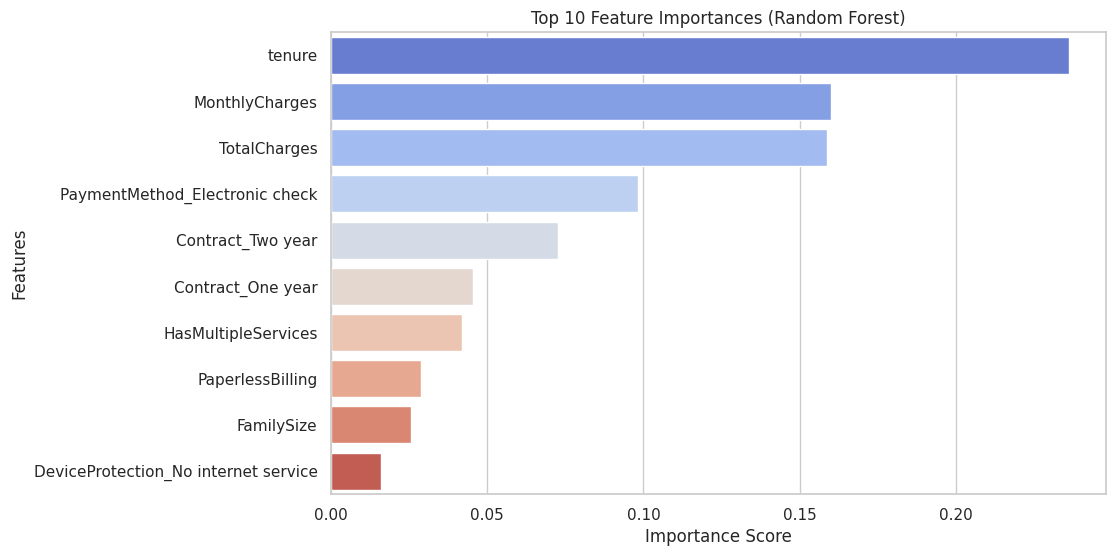

In [ ]:
# Feature importance from Random Forest
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Display top 10 important features
top_features = feature_importances.head(10)
top_features

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=top_features, y=top_features.index, palette='coolwarm')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


### Deployment and making model files

In [ ]:
import joblib

# Assuming all models are already trained and present:
# logreg, rf, svm, knn, gb are trained models.

# Saving Logistic Regression model
joblib.dump(logreg, 'logistic_regression_churn_model.pkl')

# Saving Random Forest model
joblib.dump(rf, 'random_forest_churn_model.pkl')

# Saving SVM model
joblib.dump(svm, 'svm_churn_model.pkl')

# Saving K-Nearest Neighbors model
joblib.dump(knn, 'knn_churn_model.pkl')

# Saving Gradient Boosting model
joblib.dump(gb, 'gradient_boosting_churn_model.pkl')

print("All models have been saved as .pkl files.")


All models have been saved as .pkl files.


#### Loading the saved models

In [ ]:
# Loading the saved models
logreg = joblib.load('logistic_regression_churn_model.pkl')
rf = joblib.load('random_forest_churn_model.pkl')
svm = joblib.load('svm_churn_model.pkl')
knn = joblib.load('knn_churn_model.pkl')
gb = joblib.load('gradient_boosting_churn_model.pkl')

# Example: Making predictions with Random Forest
y_pred_rf_loaded = rf.predict(X_test)
print("Loaded Random Forest Model Prediction:", y_pred_rf_loaded)


Loaded Random Forest Model Prediction: [0 1 0 ... 0 0 0]
